[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1aRY_GKu9XqXbkyIQ_tNS2zEqdn3n38sV?hl=ko#scrollTo=Ix7dTqVC7eVX)
# Supervised Learning for sentiment analysis
라벨이 있는 데이터셋을 사용한 감성 분류 모델링

In [ ]:
import random
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import string
from joblib import Parallel, delayed
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import seaborn as sns
from wordcloud import WordCloud

import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold


# Set seed
random.seed(34)
np.random.seed(34)
os.environ['PYTHONHASHSEED'] = str(34)
os.environ['TF_DETERMINISTIC_OPS'] = str(34)
tf.random.set_seed(34)

## 1. Text Sentiment Data Gathering


### ~Stanford Setiment Treebank Dataset~
- ~영화 12,000여 개 영화 리뷰 데이터를 기반으로 한 200,000개 이상의 Parse 데이터(manually labelled)~
- ~감성 분석에서 중요하게 발표되었던 데이터셋이며, 새로운 모델이 발표되기 전 테스트 용으로 사용되기도 함~
- ~이번 프로젝트에서는 뉴스 헤드라인 분석을 목표로 할 것이고, 약 10만개의 뉴스 데이터를 찾았기 때문에 해당 리뷰데이터는 사용하지 않음~

~*Reference:*<br>
https://nlp.stanford.edu/sentiment/code.html
<br>https://towardsdatascience.com/the-stanford-sentiment-treebank-sst-studying-sentiment-analysis-using-nlp-e1a4cad03065~


- Description

    Recursive Deep Models for Semantic Compositionality Over a Sentiment Treebank
    Richard Socher, Alex Perelygin, Jean Wu, Jason Chuang, Christopher Manning, Andrew Ng and Christopher Potts<br><br>
    Conference on Empirical Methods in Natural Language Processing (EMNLP 2013)
    sentiment_labels.txt contains all phrase ids and the corresponding sentiment labels, separated by a vertical line.<br>
    ***Note that you can recover the 5 classes by mapping the positivity probability using the following cut-offs:<br>
    (0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)<br>
    for very negative, negative, neutral, positive, very positive, respectively.***
    <br>Please note that phrase ids and sentence ids are not the same.
    <br><br>
    After converting all of the text to lowercase and removing non-English sentences, they use the Stanford Parser to split sentences into phrases, ending up with a total of 215,154 phrases.

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/sample_data/sentiment_text_dataset/StanfordSentimentTreebank/stanfordSentimentTreebank.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/sample_data/sentiment_text_dataset/StanfordSentimentTreebank/stanfordSentimentTreebank.zip
   creating: stanfordSentimentTreebank/
  inflating: stanfordSentimentTreebank/datasetSentences.txt  
   creating: __MACOSX/
   creating: __MACOSX/stanfordSentimentTreebank/
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSentences.txt  
  inflating: stanfordSentimentTreebank/datasetSplit.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSplit.txt  
  inflating: stanfordSentimentTreebank/dictionary.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._dictionary.txt  
  inflating: stanfordSentimentTreebank/original_rt_snippets.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._original_rt_snippets.txt  
  inflating: stanfordSentimentTreebank/README.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._README.txt  
  inflating: stanfordSentimentTreebank/sentiment_labels.txt  
  inflating: __MACOSX/stanfordSentimentTree

In [ ]:
phrase_data = pd.read_csv('/content/stanfordSentimentTreebank/sentiment_labels.txt', delimiter='|')
id = pd.read_csv('/content/stanfordSentimentTreebank/dictionary.txt', delimiter='|', header=None).sort_values(1)

In [ ]:
phrase_data['phrase'] = id[0]
phrase_data.drop(columns = 'phrase ids', inplace=True)

In [ ]:
phrase_data.head()

,sentiment values,phrase
0,0.50000,!
1,0.50000,! '
2,0.44444,! ''
3,0.50000,! Alas
4,0.42708,! Brilliant


In [ ]:
phrase_data.tail()

,sentiment values,phrase
239227,0.36111,zoning ordinances to protect your community fr...
239228,0.38889,zzzzzzzzz
239229,0.33333,élan
239230,0.88889,É
239231,0.50000,É um passatempo descompromissado


In [ ]:
phrase_data.isnull().sum()

sentiment values    0
phrase              0
dtype: int64

In [ ]:
def sentiment_calss(row):
    '''
    sentiment 
    '''
    if row['sentiment values'] <= 0.2:
        val = 'very negative'
   
    elif row['sentiment values'] > 0.2 and row['sentiment values'] <= 0.4:
        val = 'negative'
   
    elif row['sentiment values'] > 0.4 and row['sentiment values'] <= 0.6:
        val = 'neutral'
   
    elif row['sentiment values'] > 0.6 and row['sentiment values'] <= 0.8:
        val = 'positive'
   
    elif row['sentiment values'] > 0.8:
        val = 'very positive'
    
    return val

In [ ]:
phrase_data['class'] = phrase_data.apply(lambda x: sentiment_calss(x), axis=1)

In [ ]:
print(phrase_data['class'].value_counts() / len(phrase_data['class']))
print('\nShape is', phrase_data.shape)

neutral          0.499302
positive         0.209621
negative         0.179859
very positive    0.063767
very negative    0.047452
Name: class, dtype: float64

Shape is (239232, 3)


### UCI 뉴스 데이터셋<br>
미국 뉴스 93,000여 개 데이터 (topics: economy, microsoft, odbama, palestine)<br>
https://archive.ics.uci.edu/ml/datasets/News+Popularity+in+Multiple+Social+Media+Platforms#

**VARIABLES OF NEWS DATA**
- IDLink (numeric): Unique identifier of news items 
- Title (string): Title of the news item according to the official media sources 
- **Headline (string): Headline of the news item according to the official media sources**
- Source (string): Original news outlet that published the news item 
- Topic (string): Query topic used to obtain the items in the official media sources 
- PublishDate (timestamp): Date and time of the news items' publication 
- SentimentTitle (numeric): Sentiment score of the text in the news items' title 
- **SentimentHeadline (numeric): Sentiment score of the text in the news items' headline** 
- Facebook (numeric): Final value of the news items' popularity according to the social media source Facebook 
- GooglePlus (numeric): Final value of the news items' popularity according to the social media source Google+ 
- LinkedIn (numeric): Final value of the news items' popularity according to the social media source LinkedIn 

In [ ]:
uci_news_data = pd.read_csv('News_Final.csv')

print(uci_news_data.shape)
uci_news_data.head(3)

(93239, 11)


,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1


In [ ]:
uci_news_data.isnull().sum()

IDLink                 0
Title                  0
Headline              15
Source               279
Topic                  0
PublishDate            0
SentimentTitle         0
SentimentHeadline      0
Facebook               0
GooglePlus             0
LinkedIn               0
dtype: int64

In [ ]:
uci_news_data.dropna(inplace=True)

In [ ]:
# 기사 헤드라인과 sentiment score 특성 사용
# Sentiment score가 1에 가까울수록 positive, -1에 가까울수록 negative

data = uci_news_data[['Headline', 'SentimentHeadline']].reset_index().drop(columns='index')

In [ ]:
data.head(5)

,Headline,SentimentHeadline
0,Obama Lays Wreath at Arlington National Cemete...,-0.053300
1,"Tim Haywood, investment director business-unit...",-0.156386
2,"Nouriel Roubini, NYU professor and chairman at...",0.139754
3,Finland's economy expanded marginally in the t...,0.026064
4,Tourism and public spending continued to boost...,0.141084


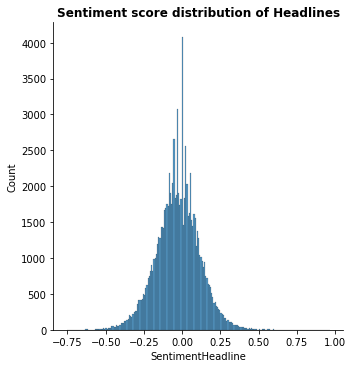


count    92945.000000
mean        -0.027490
std          0.142063
min         -0.755433
25%         -0.114598
50%         -0.026064
75%          0.059868
max          0.964646
Name: SentimentHeadline, dtype: float64


In [ ]:
sns.displot(data['SentimentHeadline'])
plt.title('Sentiment score distribution of Headlines', weight='bold')
plt.show();
print('\n======================================================')
print(data['SentimentHeadline'].describe())

In [ ]:
# 헤드라인 텍스트의 sentimet score에 따라 negative/positive/neutral로 타겟 클래스 설정

def sentiment_calss(row):
    if row['SentimentHeadline'] < -0.1:
        val = 0 # negative
    elif row['SentimentHeadline'] > 0.1:
        val = 2 # positive
    else:
        val = 1 # neutral
    
    return val

In [ ]:
data['Class'] = data.apply(lambda x: sentiment_calss(x), axis=1)
data.head()

,Headline,SentimentHeadline,Class
0,Obama Lays Wreath at Arlington National Cemete...,-0.053300,1
1,"Tim Haywood, investment director business-unit...",-0.156386,0
2,"Nouriel Roubini, NYU professor and chairman at...",0.139754,2
3,Finland's economy expanded marginally in the t...,0.026064,1
4,Tourism and public spending continued to boost...,0.141084,2


In [ ]:
data['Class'].value_counts() / len(data['Class'])

1    0.547862
0    0.284136
2    0.168003
Name: Class, dtype: float64

In [ ]:
print(data[data['Class'] == 0]['Headline'].iloc[150])
print(data[data['Class'] == 0]['Class'].iloc[150], 'negative\n')
print(data[data['Class'] == 1]['Headline'].iloc[50])
print(data[data['Class'] == 1]['Class'].iloc[50], 'neutral\n')
print(data[data['Class'] == 2]['Headline'].iloc[12150])
print(data[data['Class'] == 2]['Class'].iloc[12150], 'positive')

The only signs of life come from a new addition to the neighborhood: Microsoft's flagship retail outlet opened that morning, and now loud music
0 negative

Today Microsoft HoloLens was released for purchase - sort of - for developers, in a kit that's made strictly for those that plan on making software for the device. This version of Microsoft HoloLens is not meant to compete with the other virtual reality headsets being revealed and/or released in the next several weeks. The Oculus Rift, for example, has … Continue reading 
1 neutral

Microsoft developer Saqib Sheikh who lost his eyesight at the age of seven has developed an app to help the visually challenged. The app
2 positive


In [ ]:
data.describe()

,SentimentHeadline,Class
count,92945.000000,92945.000000
mean,-0.027490,0.883867
std,0.142063,0.662311
min,-0.755433,0.000000
25%,-0.114598,0.000000
50%,-0.026064,1.000000
75%,0.059868,1.000000
max,0.964646,2.000000


## 2. 텍스트 전처리

In [ ]:
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
nlp = spacy.load("en_core_web_lg", disable=['tagger', 'parser', 'ner'])
tokenizer = Tokenizer(nlp.vocab)
ps = PorterStemmer()

In [ ]:
def text_preprocessing(text):
    text = text.replace(r"[^a-zA-Z0-9]", " ")
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation)) # Remove punctuation [!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~]
    text = text.strip() # Remove whitespace
    text = re.sub(r'\d+', '', text) # Remove numbers
    return text

# def tokenize_pipe(text):
#     text = text.split()
#     tokens = []
#     for doc in tokenizer.pipe(text):
#         for token in doc:    
#             if (token.is_stop == False) & (token.is_punct == False) & (token.is_space == False):
#                 tokens.append(token.text)    
#     return tokens

# def get_stem(words):
#     stem =[]
#     for word in words:
#         stem.append(ps.stem(word))
#     return stem

def get_lemma(text):
    lemma_lst = [token.lemma_ for token in text
                 if (token.is_alpha==True) & (token.is_stop==False) & (token.is_punct==False) & (token.is_space==False)]
    return lemma_lst


'''
spaCy NLP pipeline speed up
https://prrao87.github.io/blog/spacy/nlp/performance/2020/05/02/spacy-multiprocess.html#Option-2:-Use-nlp.pipe
'''
def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=100):
        preproc_pipe.append(get_lemma(doc))
    return preproc_pipe

def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]
    
def preprocess_parallel(texts, chunksize=100):
    executor = Parallel(n_jobs=-1, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(data), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

In [ ]:
%%time
data['Headline'] = data['Headline'].apply(text_preprocessing)

CPU times: user 977 ms, sys: 13.6 ms, total: 991 ms
Wall time: 988 ms


In [ ]:
%%time
data['tokens'] = preprocess_parallel(data['Headline'], chunksize=3000)

CPU times: user 26.9 s, sys: 4.36 s, total: 31.3 s
Wall time: 1h 23min 25s


In [ ]:
# 중복 데이터가 있는 것을 확인하고 삭제
print('중복 데이터 수:', data.duplicated(['Headline', 'SentimentHeadline', 'Class']).sum())
data.drop_duplicates(['Headline', 'SentimentHeadline', 'Class'] ,inplace=True)
data.reset_index(drop=['index'], inplace=True)

중복 데이터 수: 6800


### data-clean.pkl save

In [ ]:
# csv로 저장 후 읽어올 때 리스트 타입의 데이터가 모두 문자열로 변환되는 문제가 발생
# 데이터프레임 원형을 보존하기 위해 pickle type으로 저장하는게 안전!
# https://stackoverflow.com/questions/49580996/why-do-my-lists-become-strings-after-saving-to-csv-and-re-opening-python
data.to_pickle('data-clean.pkl')
# !cp data-clean.pkl "/content/drive/MyDrive"

In [ ]:
clean_data = pd.read_pickle('data-clean.pkl')
print(clean_data.shape)
clean_data.head(3)

(86145, 4)


,Headline,SentimentHeadline,Class,tokens
0,obama lays wreath at arlington national cemete...,-0.053300,1,"[obama, lay, wreath, arlington, national, ceme..."
1,tim haywood investment director businessunit h...,-0.156386,0,"[tim, haywood, investment, director, businessu..."
2,nouriel roubini nyu professor and chairman at ...,0.139754,2,"[nouriel, roubini, nyu, professor, chairman, r..."


In [ ]:
clean_data.tail(3)

,Headline,SentimentHeadline,Class,tokens
86142,the palestinian government spends nearly mill...,-0.139754,0,"[palestinian, government, spend, nearly, milli..."
86143,palestine youth orchestra prepares for first u...,0.092313,1,"[palestine, youth, orchestra, prepare, uk, tou..."
86144,goldstein the proprietor of the tg travel grou...,0.054554,1,"[goldstein, proprietor, tg, travel, group, llc..."


## 2. 데이터 탐색

In [ ]:
all_tokens = [word for tokens in clean_data['tokens'] for word in tokens] # 전체 토큰
vocab = sorted(list(set(all_tokens))) # 중복 토큰 제외하고 카운트
headline_length = clean_data['Headline'].str.split().str.len()
tokens_length = clean_data['tokens'].str.len()
print("Total words:", len(all_tokens))
print("Vocab size:", len(vocab))
print("Max headline words length:", max(headline_length))
print("Max tokens length:", max(tokens_length))

Total words: 1272897
Vocab size: 48632
Max headline words length: 78
Max tokens length: 62


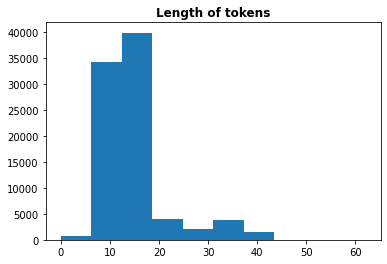

In [ ]:
plt.hist(tokens_length)
plt.title('Length of tokens', weight='bold');

In [ ]:
def word_count(docs):
    """ 
    Args: docs (series or list): 토큰화된 문서가 들어있는 list
    Returns: Dataframe
    """
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [ ]:
wc = word_count(clean_data['tokens'])
wc.head(20)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
10,obama,22004,24679,1.0,0.019388,0.019388,0.255430
18,economy,21543,23837,2.0,0.018727,0.038115,0.250078
8,president,19637,21413,3.0,0.016822,0.054937,0.227953
74,microsoft,16630,19720,4.0,0.015492,0.070429,0.193047
242,say,11101,11968,5.0,0.009402,0.079831,0.128864
3,barack,11848,11948,6.0,0.009386,0.089218,0.137536
119,new,8160,8870,7.0,0.006968,0.096186,0.094724
108,year,7916,8561,8.0,0.006726,0.102912,0.091892
977,economic,8079,8401,9.0,0.006600,0.109512,0.093784
22,state,4939,5329,10.0,0.004187,0.113698,0.057334


In [ ]:
def stopwords_add(words):
    # 과거의 뉴스 데이터이기 때문에 당시 많이 나온 단어들의 분포가 높음. 불용어 처리
    new_stopwords = ['obama', 'economy', 'president', 'say', 'microsoft', 'barack', 'obamas']
    return [word for word in words if word not in new_stopwords]

In [ ]:
clean_data['tokens'] = clean_data['tokens'].apply(stopwords_add)

In [ ]:
def wordcloud(tokens, title):
    word_cloud_dict = Counter(tokens)
    wordcloud = WordCloud().generate_from_frequencies(word_cloud_dict)

    plt.figure(figsize=(12, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, weight='bold', size=12)
    plt.savefig(f'{title}.png', dpi=300)
    plt.show();

In [ ]:
all_tokens = [word for tokens in clean_data['tokens'] for word in tokens]
negative_tokens = [word for tokens in clean_data[clean_data['Class'] == 0]['tokens'] for word in tokens]
neutral_tokens = [word for tokens in clean_data[clean_data['Class'] == 1]['tokens'] for word in tokens]
positive_tokens = [word for tokens in clean_data[clean_data['Class'] == 2]['tokens'] for word in tokens]

In [ ]:
vocab = sorted(list(set(all_tokens))) # 중복 토큰 제외하고 카운트
len(all_tokens), len(negative_tokens), len(neutral_tokens), len(positive_tokens), len(vocab)

(1155456, 338646, 626690, 190120, 48625)

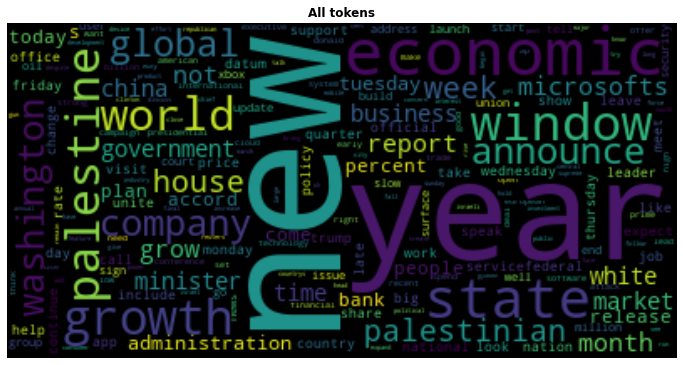

In [ ]:
wordcloud(all_tokens, 'All tokens')

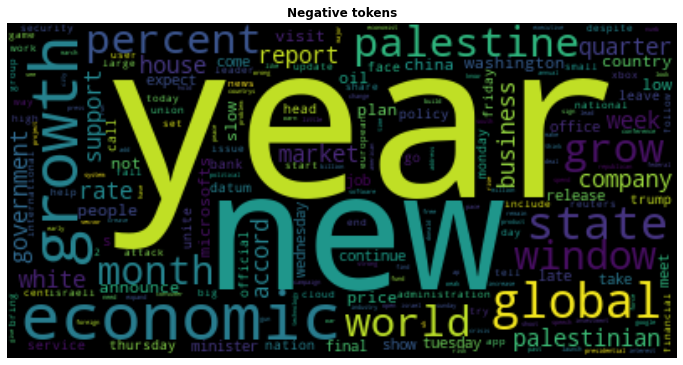

In [ ]:
wordcloud(negative_tokens, 'Negative tokens')

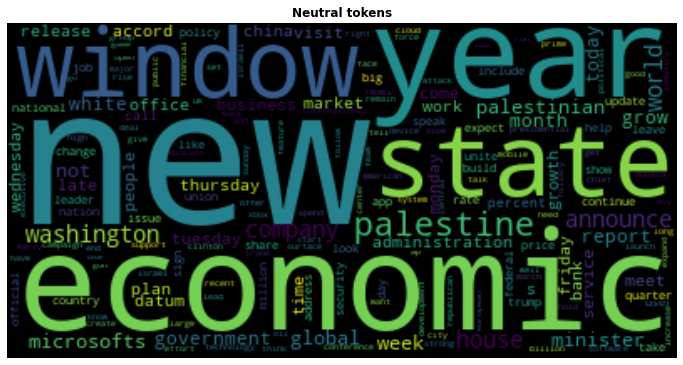

In [ ]:
wordcloud(neutral_tokens, 'Neutral tokens')

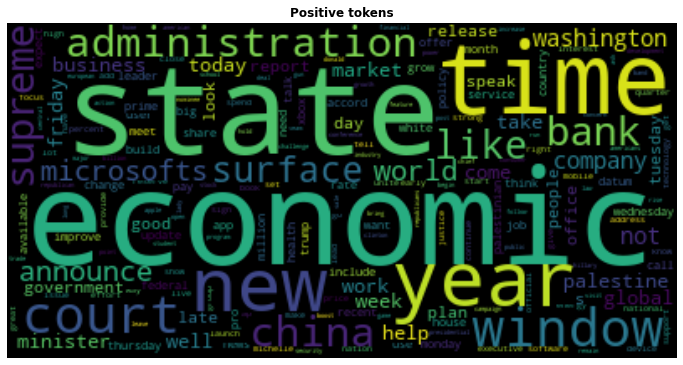

In [ ]:
wordcloud(positive_tokens, 'Positive tokens')

## BoW: TfidfVectorizer

In [ ]:
headlines = clean_data['Headline'].tolist()
tokens = clean_data['tokens'].tolist()
labels = clean_data['Class'].tolist()

len(headlines), len(tokens), len(labels)

(86145, 86145, 86145)

In [ ]:
X_train_tokens, X_test_tokens, y_train_tokens, y_test_tokens = train_test_split(tokens, labels, test_size=0.3, stratify=labels, random_state=34)

len(X_train_tokens), len(X_test_tokens), len(y_train_tokens), len(y_test_tokens)

(60301, 25844, 60301, 25844)

In [ ]:
%%time
X_train_tokens, X_test_tokens, y_train_tokens, y_test_tokens = train_test_split(tokens, labels, test_size=0.3, stratify=labels, random_state=34)

len(X_train_tokens), len(X_test_tokens), len(y_train_tokens), len(y_test_tokens)
def identify_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identify_tokenizer,
                        stop_words='english',
                        lowercase=False)

tfidf_X_train = tfidf.fit_transform(X_train_tokens)
tfidf_X_test = tfidf.transform(X_test_tokens)
# dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 1.27 s, sys: 11.9 ms, total: 1.28 s
Wall time: 1.28 s


In [ ]:
tfidf_X_train, tfidf_X_test, tfidf

(<60301x40480 sparse matrix of type '<class 'numpy.float64'>'
 	with 757980 stored elements in Compressed Sparse Row format>,
 <25844x40480 sparse matrix of type '<class 'numpy.float64'>'
 	with 316907 stored elements in Compressed Sparse Row format>,
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=False, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words='english', strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=<function identify_tokenizer at 0x7f640a899a70>,
                 use_idf=True, vocabulary=None))

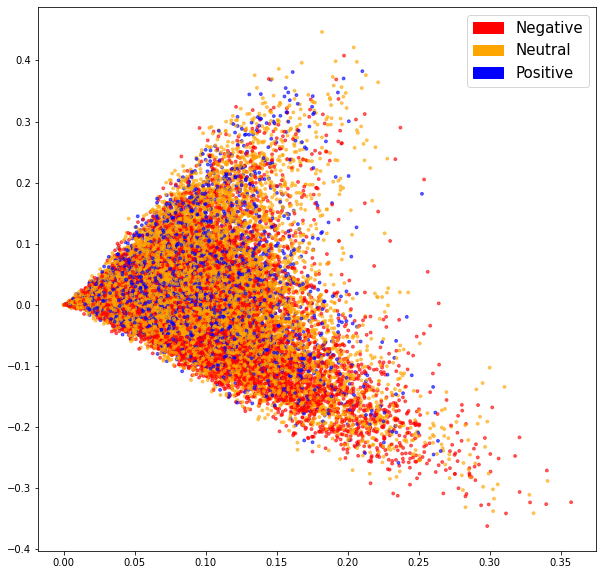

In [ ]:
def plot_LSA(data, labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(data)
    lsa_scores = lsa.transform(data)
    color_mapper = {label:idx for idx,label in enumerate(set(labels))}
    colors = ['red', 'orange', 'blue']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1],
                    s=8, alpha=.6, c=labels, cmap=ListedColormap(colors))
        
        red_patch = mpatches.Patch(color='red', label='Negative')
        orange_patch = mpatches.Patch(color='orange', label='Neutral')
        green_patch = mpatches.Patch(color='blue', label='Positive')
        plt.legend(handles=[red_patch, orange_patch, green_patch], prop={'size':15})


fig = plt.figure(figsize=(10,10))
plot_LSA(tfidf_X_train, y_train)

### LSA

#### Pipeline: RandomForestClassifier, TruncatedSVD

In [ ]:

vect = tfidf
svd = TruncatedSVD(algorithm='randomized', n_iter=5, random_state=34)
rfc = RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=34, n_jobs=-1)

vect, svd, rfc

(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=False, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words='english', strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=<function identify_tokenizer at 0x7f640a899a70>,
                 use_idf=True, vocabulary=None),
 TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5, random_state=34,
              tol=0.0),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='entropy', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_sam

In [ ]:
%%time
lsa_pipe = Pipeline([
                #  ('vect', tfidf),
                 ('svd', svd),
                 ('clf', rfc)
], verbose=True)

lsa_pipe.fit(tfidf_X_train, y_train)

[Pipeline] ............... (step 1 of 2) Processing svd, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.4min
CPU times: user 5min 35s, sys: 2.5 s, total: 5min 37s
Wall time: 1min 26s


              precision    recall  f1-score   support

           0       0.32      0.23      0.27      7297
           1       0.55      0.74      0.63     14181
           2       0.18      0.08      0.11      4366

    accuracy                           0.48     25844
   macro avg       0.35      0.35      0.33     25844
weighted avg       0.42      0.48      0.44     25844



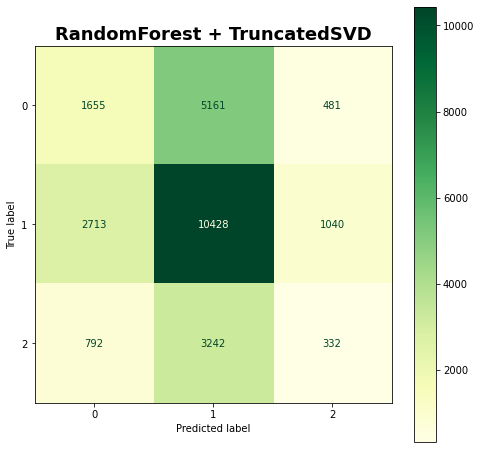

[[ 1655  5161   481]
 [ 2713 10428  1040]
 [  792  3242   332]]


In [ ]:
tfidf_y_pred = lsa_pipe.predict(tfidf_X_test)
print(classification_report(y_test, tfidf_y_pred))

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(lsa_pipe, tfidf_X_test, y_test, values_format='.0f', cmap='YlGn', ax=ax)
plt.title('RandomForest + TruncatedSVD', weight='bold', size=18)
plt.savefig('Cofusion-matrix-randomforest+svd.png', dpi=300)
plt.show();

print(confusion_matrix(y_test, tfidf_y_pred))

#### Logistic Regression: baseline model

In [ ]:
%%time

lr_tfidf = LogisticRegression(C=30.0,
                               class_weight='balanced',
                               solver='newton-cg',
                               multi_class='multinomial',
                               n_jobs=-1,
                               random_state=34)

lr_tfidf.fit(tfidf_X_train, y_train)

CPU times: user 104 ms, sys: 348 ms, total: 452 ms
Wall time: 12 s


              precision    recall  f1-score   support

           0       0.52      0.58      0.55      7297
           1       0.66      0.56      0.60     14181
           2       0.42      0.54      0.47      4366

    accuracy                           0.56     25844
   macro avg       0.53      0.56      0.54     25844
weighted avg       0.58      0.56      0.57     25844



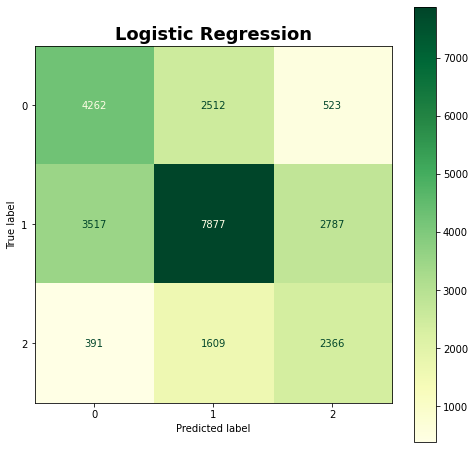

[[4262 2512  523]
 [3517 7877 2787]
 [ 391 1609 2366]]


In [ ]:
tfidf_y_pred = lr_tfidf.predict(tfidf_X_test)
print(classification_report(y_test, tfidf_y_pred))

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(lr_tfidf, tfidf_X_test, y_test, values_format='.0f', cmap='YlGn', ax=ax)
plt.title('Logistic Regression', weight='bold', size=18)
plt.savefig('Cofusion-matrix-logisticregression.png', dpi=300)

plt.show();

print(confusion_matrix(y_test, tfidf_y_pred))

## Using LSTM layer

In [ ]:
headlines = clean_data['Headline']
labels = clean_data['Class']
X_train, X_test, y_train, y_test = train_test_split(headlines, labels, test_size=.3, stratify=labels, random_state=34)
len(X_train), len(y_train), len(X_test), len(y_test)

(60301, 60301, 25844, 25844)

In [ ]:
vocab_size = len(vocab)

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print('Unique tokens in all documnets:', len(word_index))

maxlen = max([len(s.split()) for s in X_train])
embedding_dim = 128
max_features = len(word_index) + 1

Unique tokens in all documnets: 52435


In [ ]:
X_train_padding = pad_sequences(X_train_encoded, maxlen=maxlen)
X_test_padding = pad_sequences(X_test_encoded, maxlen=maxlen)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(X_train_encoded[0])
print(X_train_padding[0])
print(X_test_encoded[0])
print(X_test_padding[0])

[9, 15, 1791, 62, 15, 14349, 26, 11358, 5644, 56, 614, 2917, 982, 8554]
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     9    15  1791    62    15 14349    26 11358
  5644    56   614  2917   982  8554]
[905, 234, 109, 10, 356, 15, 2299, 3789, 2, 1, 3796, 6929, 490, 56, 1, 413, 58, 3, 1, 57, 11, 27, 4]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0  905
  234  109   10  356   15 2299 3789    2    1 3796 6929  490   56  

In [ ]:
X_train_padding.shape, y_train.shape, X_test_padding.shape, y_test.shape

((60301, 78), (60301,), (25844, 78), (25844,))

In [ ]:
def create_model_lstm():
    model = Sequential(name='lstmLayerUsing')
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(LSTM(1024, kernel_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model

model = create_model_lstm()
model.summary()

Model: "lstmLayerUsing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 78, 128)           6711808   
_________________________________________________________________
lstm (LSTM)                  (None, 1024)              4722688   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)            

In [ ]:
checkpoint_filepath = 'lstmLayerUsing-weights-best.hdf5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                         monitor='val_loss',
                                                         verbose=1,
                                                         mode='auto',
                                                         save_freq='epoch',
                                                         save_best_only=True,
                                                         save_weights_only=True)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               mode='min',
                                               min_delta=0, 
                                               verbose=1,
                                               patience=5)

In [ ]:
model.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

EPOCHS = 100
batch_size = 1024

history = model.fit(X_train_padding, y_train,
                    batch_size=batch_size,
                    epochs=EPOCHS,
                    validation_data=(X_test_padding, y_test),
                    callbacks=[checkpoint_callback, es_callback],
                    verbose=1)

Epoch 1/100
59/59 [==============================] - 28s 442ms/step - loss: 1.1543 - accuracy: 0.5254 - val_loss: 0.9768 - val_accuracy: 0.5487

Epoch 00001: val_loss improved from inf to 0.97681, saving model to /content/drive/MyDrive/lstmLayerUsing-weights-best.hdf5
Epoch 2/100
59/59 [==============================] - 25s 426ms/step - loss: 0.9182 - accuracy: 0.5726 - val_loss: 0.9245 - val_accuracy: 0.5568

Epoch 00002: val_loss improved from 0.97681 to 0.92447, saving model to /content/drive/MyDrive/lstmLayerUsing-weights-best.hdf5
Epoch 3/100
59/59 [==============================] - 25s 426ms/step - loss: 0.7146 - accuracy: 0.6689 - val_loss: 0.5751 - val_accuracy: 0.7658

Epoch 00003: val_loss improved from 0.92447 to 0.57514, saving model to /content/drive/MyDrive/lstmLayerUsing-weights-best.hdf5
Epoch 4/100
59/59 [==============================] - 25s 427ms/step - loss: 0.3678 - accuracy: 0.8698 - val_loss: 0.5769 - val_accuracy: 0.7758

Epoch 00004: val_loss did not improve fr

In [ ]:
loss, acc = model.evaluate(X_test_padding, y_test, batch_size=batch_size)

26/26 [==============================] - 3s 117ms/step - loss: 0.8934 - accuracy: 0.7623


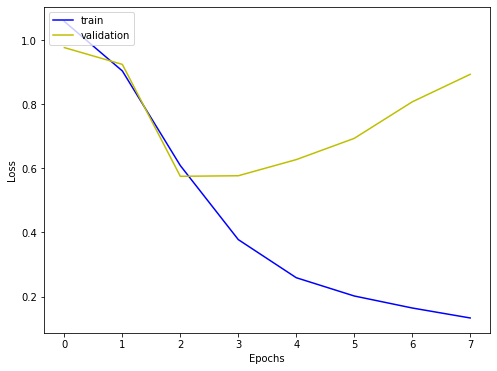

In [ ]:
fig, axes = plt.subplots(figsize=(8,6))
axes.plot(history.history['loss'], 'b', label='train')
axes.plot(history.history['val_loss'], 'y', label='validation')
axes.set_xlabel('Epochs')
axes.set_ylabel('Loss')
axes.legend(loc='upper left')
plt.show();

In [ ]:
y_pred = model.predict(X_test_padding)
predicted_class = np.argmax(y_pred, axis=1)
print(classification_report(y_test, predicted_class))
print(confusion_matrix(y_test, predicted_class))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76      7297
           1       0.81      0.75      0.78     14181
           2       0.68      0.73      0.71      4366

    accuracy                           0.76     25844
   macro avg       0.74      0.76      0.75     25844
weighted avg       0.77      0.76      0.76     25844

[[ 5857  1367    73]
 [ 2093 10636  1452]
 [   69  1089  3208]]


In [ ]:
model.save('lstmLayerUsing_model.h5')

### 저장된 가중치 불러오기

In [ ]:
### 저장한 모델 불러와서 다시 작업

# 가중치 불러오기
model = create_model_lstm()
model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print('without loading weights:')
model.evaluate(X_test_padding, y_test, batch_size=batch_size)

model.load_weights('lstmLayerUsing-weights-best.hdf5')
print('after loading weights:')
loss, acc = model.evaluate(X_test_padding, y_test, batch_size=batch_size)

Model: "lstmLayerUsing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 78, 128)           6711808   
_________________________________________________________________
lstm_14 (LSTM)               (None, 1024)              4722688   
_________________________________________________________________
dropout_42 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_43 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_44 (Dropout)         (None, 256)            

In [ ]:
# # 모델 통째로 불러오기
# # epoch 돌 때 저장이 되지 않고, 학습이 끝난 후 save_model 했더니 최적의 loss값으로 저장되지 않음
# model = tf.keras.models.load_model('/content/drive/MyDrive/lstmLayerUsing_model.h5')
# loss, acc = model.evaluate(X_test_padding, y_test, batch_size=batch_size)

26/26 [==============================] - 3s 117ms/step - loss: 0.8934 - accuracy: 0.7623


### 5-fold CV

In [ ]:
X_padding = np.concatenate((X_train_padding, X_test_padding), axis=0)
y_padding = np.concatenate((y_train, y_test), axis=0)
X_padding.shape, y_padding.shape

((86145, 78), (86145,))

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=34)
cv_scores = []

for train, test in kfold.split(X_padding, y_padding):
    model = create_model_lstm()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(X_padding[train], y_padding[train], epochs=5, batch_size=batch_size, verbose=1)
    
    loss, acc = model.evaluate(X_padding[test], y_padding[test], verbose=0)
    
    print(f'{model.metrics_names[1]}: {acc}')
    print(f'{model.metrics_names[0]}: {loss}')

    cv_scores.append(acc * 100)

print(f'5-fold cv mean: {np.mean(cv_scores)}%')
print(f'5-fold cv std: +/-{np.std(cv_scores)}%')

Epoch 1/5
68/68 [==============================] - 27s 374ms/step - loss: 1.0825 - accuracy: 0.5184
Epoch 2/5
68/68 [==============================] - 25s 373ms/step - loss: 0.8159 - accuracy: 0.6166
Epoch 3/5
68/68 [==============================] - 25s 373ms/step - loss: 0.6168 - accuracy: 0.7456
Epoch 4/5
68/68 [==============================] - 25s 374ms/step - loss: 0.3191 - accuracy: 0.8889
Epoch 5/5
68/68 [==============================] - 25s 372ms/step - loss: 0.2280 - accuracy: 0.9287
accuracy: 0.7789773344993591
loss: 0.6397639513015747
Epoch 1/5
68/68 [==============================] - 27s 375ms/step - loss: 1.2659 - accuracy: 0.5440
Epoch 2/5
68/68 [==============================] - 25s 372ms/step - loss: 0.8668 - accuracy: 0.5938
Epoch 3/5
68/68 [==============================] - 25s 372ms/step - loss: 0.4738 - accuracy: 0.8125
Epoch 4/5
68/68 [==============================] - 25s 373ms/step - loss: 0.2971 - accuracy: 0.8997
Epoch 5/5
68/68 [=============================

### Hyperparameters tuning: Kerastuner

In [ ]:
!pip install keras-tuner

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import kerastuner as kt
import IPython

In [ ]:
create_model_lstm().summary()
max_features, embedding_dim, maxlen

Model: "lstmLayerUsing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 78, 128)           6711808   
_________________________________________________________________
lstm_7 (LSTM)                (None, 1024)              4722688   
_________________________________________________________________
dropout_21 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)            

(52436, 128, 78)

In [ ]:
def model_builder(hp):

    model = Sequential(name='lstmLayerUsing_kerastuner')

    hp_units_1 = hp.Int('units_1', min_value=32, max_value=1024, step=64)
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=1024, step=64)
    hp_units_3 = hp.Int('units_3', min_value=32, max_value=1024, step=64)
    hp_units_4 = hp.Int('units_4', min_value=32, max_value=1024, step=64)
    hp_activation_1 = hp.Choice('dense_activation_1', values=['relu', 'tanh', 'sigmoid'], default='relu')
    hp_activation_2 = hp.Choice('dense_activation_2', values=['relu', 'tanh', 'sigmoid'], default='relu')
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.4, step=0.1)
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.4, step=0.1)
    hp_dropout_3 = hp.Float('dropout_3', min_value=0.1, max_value=0.4, step=0.1)

    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    
    model.add(LSTM(units=hp_units_1, kernel_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(hp_dropout_1))
    model.add(Dense(units=hp_units_2, activation=hp_activation_1, kernel_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(hp_dropout_2))
    model.add(Dense(units=hp_units_3, activation=hp_activation_2, kernel_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(hp_dropout_3))
    model.add(Dense(units=hp_units_4, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     seed=34,
                     max_epochs=20,
                    #  executions_per_trial=100,
                     directory='tuning',
                     project_name='lstm_sentiment'
)

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
tuner.search(X_train_padding, y_train,
             epochs=30,
             batch_size=batch_size,
             validation_data=(X_test_padding, y_test),
             callbacks=[ClearTrainingOutput(), es_callback]
)

Trial 30 Complete [00h 08m 25s]
val_loss: 0.685733437538147

Best val_loss So Far: 0.5199840068817139
Total elapsed time: 00h 39m 24s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# 튜너로 찾은 최적의 파라미터 확인
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
[Best parameters]
unit_1: {best_hps.get('units_1')}
unit_2: {best_hps.get('units_2')}
unit_3: {best_hps.get('units_3')}
unit_4: {best_hps.get('units_4')}
activation_1: {best_hps.get('dense_activation_1')}
activation_2: {best_hps.get('dense_activation_2')}
dropout_1: {best_hps.get('dropout_1')}
dropout_2: {best_hps.get('dropout_2')}
dropout_3: {best_hps.get('dropout_3')}
"""
)


[Best parameters]
unit_1: 96
unit_2: 736
unit_3: 544
unit_4: 416
activation_1: sigmoid
activation_2: sigmoid
dropout_1: 0.30000000000000004
dropout_2: 0.4
dropout_3: 0.2



In [ ]:
# 튜닝된 모델로 재학습
model_hp = tuner.hypermodel.build(best_hps)
history = model_hp.fit(X_train_padding, y_train,
                    batch_size=batch_size,
                    epochs=50,
                    validation_data=(X_test_padding, y_test),
                    callbacks=[checkpoint_callback, es_callback],
                    verbose=1)

Epoch 1/50
59/59 [==============================] - 6s 76ms/step - loss: 1.1904 - accuracy: 0.4829 - val_loss: 0.9941 - val_accuracy: 0.5487

Epoch 00001: val_loss improved from inf to 0.99412, saving model to /content/drive/MyDrive/lstmLayerUsing-weights-best.hdf5
Epoch 2/50
59/59 [==============================] - 4s 68ms/step - loss: 0.9474 - accuracy: 0.5640 - val_loss: 0.6641 - val_accuracy: 0.7201

Epoch 00002: val_loss improved from 0.99412 to 0.66406, saving model to /content/drive/MyDrive/lstmLayerUsing-weights-best.hdf5
Epoch 3/50
59/59 [==============================] - 4s 68ms/step - loss: 0.5554 - accuracy: 0.7800 - val_loss: 0.5311 - val_accuracy: 0.7941

Epoch 00003: val_loss improved from 0.66406 to 0.53107, saving model to /content/drive/MyDrive/lstmLayerUsing-weights-best.hdf5
Epoch 4/50
59/59 [==============================] - 4s 67ms/step - loss: 0.3572 - accuracy: 0.8786 - val_loss: 0.5298 - val_accuracy: 0.8028

Epoch 00004: val_loss improved from 0.53107 to 0.529

In [ ]:
model_hp.summary()

Model: "lstmLayerUsing_kerastuner"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 78, 128)           6711808   
_________________________________________________________________
lstm (LSTM)                  (None, 96)                86400     
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 736)               71392     
_________________________________________________________________
dropout_1 (Dropout)          (None, 736)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 544)               400928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 544) 

In [ ]:
# tf.keras.utils.plot_model(model_hp, 
#                           to_file='lstmLayerUsing_kerastuner_model.png', 
#                           show_shapes=True,
#                           show_layer_names=True,
#                           rankdir='TB',
#                           dpi=100)

loss, acc = model_hp.evaluate(X_test_padding, y_test, batch_size=batch_size)

26/26 [==============================] - 0s 13ms/step - loss: 0.7815 - accuracy: 0.7865


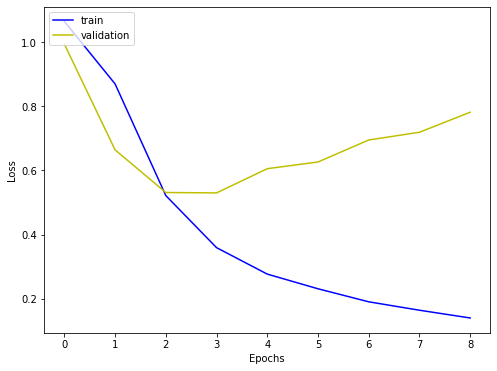

In [ ]:
fig, axes = plt.subplots(figsize=(8,6))
axes.plot(history.history['loss'], 'b', label='train')
axes.plot(history.history['val_loss'], 'y', label='validation')
axes.set_xlabel('Epochs')
axes.set_ylabel('Loss')
axes.legend(loc='upper left')
plt.show();

In [ ]:
y_pred = model_hp.predict(X_test_padding)
predicted_class = np.argmax(y_pred, axis=1)
print(classification_report(y_test, predicted_class))
print(confusion_matrix(y_test, predicted_class))

              precision    recall  f1-score   support

           0       0.78      0.75      0.77      7297
           1       0.80      0.82      0.81     14181
           2       0.74      0.74      0.74      4366

    accuracy                           0.79     25844
   macro avg       0.77      0.77      0.77     25844
weighted avg       0.79      0.79      0.79     25844

[[ 5508  1755    34]
 [ 1468 11580  1133]
 [   48  1079  3239]]


## 헤드라인 텍스트 감성분석 예측

In [ ]:
from textblob import TextBlob
import time

In [ ]:
def ReadyForPrediction(text):
    '''
    Arg: text string
    Return: (cleaning + tokenize + padding) text
    '''
    text = text_preprocessing(text)
    text = tokenizer.texts_to_sequences([text]) # 헤드라인 하나만 문자열로 넘겨주기 때문에 리스트로 만들어서 토크나이즈 해줘야함. 그렇지 않으면 캐릭터 하나하나 잘라버림
    text = pad_sequences(text, maxlen=maxlen)
    return text


def translate_to_en(headline):
    detect = TextBlob(headline).detect_language()

    if detect == 'en':
        return headline
    else:
        translated_headline = str(TextBlob(headline).translate(to='en'))
        return translated_headline

    time.sleep(1)


def sentiment_prediction(text):
    # 하나의 문자열 텍스트만 인자로 받음
    translated_text = translate_to_en(text)
    predict_proba = model_hp.predict(ReadyForPrediction(translated_text))
    proba = round(np.max(predict_proba) * 100, 2)
    sentiment = np.argmax(predict_proba, axis=1)
    
    if sentiment == 0:
        sentiment = 'Negtive'
    if sentiment == 1:
        sentiment = 'Neutral'
    if sentiment == 2:
        sentiment = 'Positive'
    
    print('Headline:', text)
    print('Translated:', translated_text)
    print(f'Sentiment: {sentiment} in {proba}%')
    print('='*100, '\n')

In [ ]:
# 훈련/테스트 전체 데이터에서 임의로 5개 가졍와서 예측
for t in np.random.choice(headlines, 5):
    sentiment_prediction(t)

# cnn 웹페이지에서 가져온 기사 헤드라인으로 테스트
sentiment_prediction('Terror investigation opened after female police employee fatally stabbed at police station in Rambouillet, France')
sentiment_prediction('The US justice department announces probe into Minneapolis police practices after George Floyd murder verdict')
sentiment_prediction('Wales football manager Ryan Giggs charged with assaulting two women')
sentiment_prediction('India is experiencing the world\'s worst coronavirus outbreak. Here\'s how you can help.')

Headline: as legendary military strategist yogi berra once said it aint over til its over according to barack obama the war in afghanistan was supposed
Translated: as legendary military strategist yogi berra once said it aint over til its over according to barack obama the war in afghanistan was supposed
Sentiment: Neutral in 99.72%

Headline: microsoft released the older version around a year ago in march  where it was noted to have a thin design a full number keypad and
Translated: microsoft released the older version around a year ago in march  where it was noted to have a thin design a full number keypad and
Sentiment: Neutral in 99.72%

Headline: were just  days into  so the new year is still an infant crying to be adopted by a nurturing economic forecast here are a few
Translated: were just  days into  so the new year is still an infant crying to be adopted by a nurturing economic forecast here are a few
Sentiment: Neutral in 99.66%

Headline: economy vicepresident miguel perez t

In [ ]:
# 훈련/테스트 전체 데이터에서 임의로 5개 가졍와서 예측
for t in np.random.choice(headlines, 5):
    sentiment_prediction(t)

# cnn 웹페이지에서 가져온 기사 헤드라인으로 테스트
sentiment_prediction('Terror investigation opened after female police employee fatally stabbed at police station in Rambouillet, France')
sentiment_prediction('The US justice department announces probe into Minneapolis police practices after George Floyd murder verdict')
sentiment_prediction('Wales football manager Ryan Giggs charged with assaulting two women')
sentiment_prediction('India is experiencing the world\'s worst coronavirus outbreak. Here\'s how you can help.')

Headline: microsoft has once again delayed its ambitious surface hub device launch originally scheduled for release in september to april or later
Translated: microsoft has once again delayed its ambitious surface hub device launch originally scheduled for release in september to april or later
Sentiment: Positive in 91.67%

Headline: new yorkbusiness wirecontinued appreciation of the us dollar usd relative to the euro would affect net exports with knockon
Translated: new yorkbusiness wirecontinued appreciation of the us dollar usd relative to the euro would affect net exports with knockon
Sentiment: Neutral in 95.26%

Headline: the party said with the inauguration the apc administration should fully resolve the issues on the actual position of the nations economy and
Translated: the party said with the inauguration the apc administration should fully resolve the issues on the actual position of the nations economy and
Sentiment: Neutral in 81.88%

Headline: wafa  a slight rise in temp

## Using Twitterr api

In [ ]:
import tweepy
import json

In [ ]:
file_path = '/content/drive/MyDrive/twitter.json'
with open(file_path, 'r') as f:
    data = json.load(f)

api_key = data['api_key']
api_secret = data['api_secret']
access_token = data['access_token']
access_secrret = data['access_secret']

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_secrret)

api = tweepy.API(auth)

In [ ]:
def get_timeline(screen_name):
    '''
    1. 뉴스채널 트위터 계정의 타임라인을 불러옴
    2. 불러온 타임라인에서 username, location, headline, link 추출
    3. 각 키에 맞는 값들을 딕셔너리에 담아서 리턴
    '''
    tweets = api.user_timeline(screen_name=screen_name,
                            tweet_mode='extended',
                            include_rts=False,
                            count=10,
                            exclude_replies=True)

    username = []
    location = []
    text = []
    headline = []
    link = []
    
    for t in tweets:
        username.append(t._json['user']['screen_name'])
        location.append(t._json['user']['location'])
        text.append(t.full_text)

    for i in range(len(text)):
        headline.append(text[i].split('https')[0])
        for word in text[i].split():
            http_link = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$\-@\.&+:/?=]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', word) # 정규식으로 http 링크 주소 찾아주기, 리스트로 돌려줌
            if http_link: # 값이 빈 []가 아니라면 링크 리스트에 넣어줌
                link.append(http_link[0])

    timeline_dict = {'username' : username,
                    'location' : location,
                    'headline' : headline,
                    'link' : link}


    return timeline_dict['headline']

In [ ]:
# 한국어 원본 헤드라인과, 변역본, 예측 결과가 함께 나오도록 수정
def twit_predict(screen_name):
    '''
    Arg: twitter screen_name('string')
    '''
    for t in get_timeline(screen_name):
        sentiment_prediction(t)
        time.sleep(1)

twit_predict('mbcnews')

Headline: 황사에 비까지 섞여 내리면서 궂은 날씨가 예상됩니다.

Translated: Inclement weather is expected as the yellow sand and rain are mixed.
Sentiment: Neutral in 98.15%

Headline: 호날두와 메시에 가려져있던 또 한 명의 '챔피언스리그 사나이' 이야기로 톱플레이 출발합니다.

Translated: Top play starts with the story of another'Champions League Man' who was hidden by Ronaldo and Messi.
Sentiment: Negtive in 98.41%

Headline: 뒤늦게 흥행에 성공하는 가요계의 역주행 신드롬이 요즘 KBO리그에도 있습니다.

Translated: There is also a syndrome of reverse driving in the music industry that succeeds in being a late box office in the KBO league.
Sentiment: Neutral in 99.72%

Headline: 김학범 올림픽축구대표팀 감독이 손흥민 선수도 와일드카드 후보로 고려 중이라고 밝혔습니다.

Translated: Olympic football team coach Kim Hak-beom said that Son Heung-min is also considering a wildcard candidate.
Sentiment: Neutral in 99.67%

Headline: 오늘은 한 선수가 실신해서 응급실로 실려가 양성 판정을 받는 일까지 벌어졌습니다.

Translated: Today, a player fainted and was taken to the emergency room to be tested positive.
Sentiment: Negtive in 97.78%



In [ ]:
# 영문 헤드라인 예측
twit_predict('cnn')

Headline: Saudi Arabia is considering selling part of its giant state oil company to a major foreign investor, likely from China 
Translated: Saudi Arabia is considering selling part of its giant state oil company to a major foreign investor, likely from China 
Sentiment: Neutral in 98.07%

Headline: Here's what's in President Biden's $1.8 trillion American Families Plan 
Translated: Here's what's in President Biden's $1.8 trillion American Families Plan 
Sentiment: Neutral in 98.99%

Headline: How the Biden presidency looks from one pivotal Pennsylvania county, 100 days in 
Translated: How the Biden presidency looks from one pivotal Pennsylvania county, 100 days in 
Sentiment: Neutral in 99.69%

Headline: A juror in the Derek Chauvin trial says every day in the courtroom felt like a funeral 
Translated: A juror in the Derek Chauvin trial says every day in the courtroom felt like a funeral 
Sentiment: Negtive in 78.8%

Headline: 15 of the safest activities for the fully vaccinated — wi

### Test

In [ ]:
clean_data.head()

,Headline,SentimentHeadline,Class,tokens
0,obama lays wreath at arlington national cemete...,-0.053300,1,"[lay, wreath, arlington, national, cemetery, l..."
1,tim haywood investment director businessunit h...,-0.156386,0,"[tim, haywood, investment, director, businessu..."
2,nouriel roubini nyu professor and chairman at ...,0.139754,2,"[nouriel, roubini, nyu, professor, chairman, r..."
3,finlands economy expanded marginally in the th...,0.026064,1,"[finlands, expand, marginally, month, end, dec..."
4,tourism and public spending continued to boost...,0.141084,2,"[tourism, public, spend, continue, boost, janu..."


In [ ]:
X_train.shape, X_train_padding.shape, X_test.shape, X_test_padding.shape, y_train.shape, y_test.shape

((60301,), (60301, 78), (25844,), (25844, 78), (60301,), (25844,))

In [ ]:
### Kerastuner model reload
def tuner_model():
    model_hp = Sequential()
    model_hp.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model_hp.add(LSTM(96, kernel_regularizer=regularizers.l2(1e-5)))
    model_hp.add(Dropout(0.3))
    model_hp.add(Dense(736, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-5)))
    model_hp.add(Dropout(0.4))
    model_hp.add(Dense(544, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-5)))
    model_hp.add(Dropout(0.2))
    model_hp.add(Dense(416, activation='relu'))
    model_hp.add(Dense(3, activation='softmax'))
    return model_hp

model_hp = tuner_model()
model_hp.summary()

model_hp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 가중치 불러오기
model_hp.load_weights('lstmLayerUsing-weights-best.hdf5')

loss, acc = model_hp.evaluate(X_test_padding, y_test, batch_size=batch_size)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 78, 128)           6711808   
_________________________________________________________________
lstm_12 (LSTM)               (None, 96)                86400     
_________________________________________________________________
dropout_36 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 736)               71392     
_________________________________________________________________
dropout_37 (Dropout)         (None, 736)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 544)               400928    
_________________________________________________________________
dropout_38 (Dropout)         (None, 544)              

In [ ]:
y_pred = model_hp.predict(X_test_padding)
predicted_class = np.argmax(y_pred, axis=1)
print(classification_report(y_test, predicted_class))
print(confusion_matrix(y_test, predicted_class))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      7297
           1       0.82      0.82      0.82     14181
           2       0.78      0.74      0.76      4366

    accuracy                           0.80     25844
   macro avg       0.79      0.79      0.79     25844
weighted avg       0.80      0.80      0.80     25844

[[ 5864  1396    37]
 [ 1635 11661   885]
 [   56  1087  3223]]


In [ ]:
def twit_predict(screen_name):
    '''
    Arg: twitter screen_name('string')
    '''
    for t in get_timeline(screen_name):
        sentiment_prediction(t)
        time.sleep(1)

In [ ]:
twit_predict('mbcnews')

Headline: 사건이 벌어진 곳은 임종을 앞둔 환자들이 주로 머무는 곳으로 전해졌습니다.

Translated: The place where the incident took place was reported to the place where patients on the verge of death usually stay.
Sentiment: Negtive in 93.98%

Headline: 자가검사키트를 학교에 제한적으로 도입하기로 결정했다고 밝혔습니다.

Translated: It has been revealed that it has decided to introduce limited self-test kits to schools.
Sentiment: Neutral in 85.77%

Headline: 김 후보자는  "기증하기로 한 문화재엔 국보급도 포함된 것으로 안다"며 "귀한 문화재를 국민의 품으로 돌려주기로 한 것은 고맙게 생각하지만, 사면은 사면권을 갖고 있는 대통령이 결정할 문제로 기증 하나를 놓고 볼 수는 없다"고 밝혔습니다. 
Translated: Candidate Kim said, "I know that the cultural assets I decided to donate include national treasures." I can't."
Sentiment: Neutral in 96.89%

Headline: 하마평에 올랐던 정청래 의원에 대해서는 "정청래 의원은 별도의 본인 생각이 있었으니까 윤호중 원내대표가 오늘 아침 전화해서 양해를 구했다"고 말했습니다. 
Translated: Regarding Congressman Chung Cheong-rae, who had been on the Haapyeong, he said, "Counselor Chung Cheong-rae had a separate opinion, so Ho-joong Yun called and asked for patience this morning.
Sentiment

In [ ]:
twit_predict('bbcbreaking')

Headline: US astronaut Michael Collins, who orbited the moon during the first landing on the surface, dies aged 90, family says 
Translated: US astronaut Michael Collins, who orbited the moon during the first landing on the surface, dies aged 90, family says 
Sentiment: Positive in 73.02%

Headline: UK orders extra 60 million doses of Pfizer-BioNTech Covid vaccine, as government puts plan in place for booster programme in the autumn 
Translated: UK orders extra 60 million doses of Pfizer-BioNTech Covid vaccine, as government puts plan in place for booster programme in the autumn 
Sentiment: Neutral in 82.82%

Headline: Arlene Foster to step down as Northern Ireland's first minister and leader of the DUP 
Translated: Arlene Foster to step down as Northern Ireland's first minister and leader of the DUP 
Sentiment: Neutral in 69.04%

Headline: Electoral Commission to investigate funding of UK prime minister's Downing Street flat, saying there are "reasonable grounds to suspect an offence"

## KoNLPy 

In [ ]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

In [ ]:
from konlpy.tag import Mecab
import konlpy
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import urllib.request

### 네이버 영화 리뷰 데이터
뉴스 헤드라인 데이터와 맞지 않는 것 같아서 일단 패스

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f2c693d12d0>)

In [ ]:
data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
data.head()

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [ ]:
data.isnull().sum()

ratings    0
reviews    0
dtype: int64

In [ ]:
data['ratings'].value_counts() / len(data['ratings'])

5    0.405885
2    0.319945
1    0.180240
4    0.093930
Name: ratings, dtype: float64

In [ ]:
data[data['ratings'] == 2]

,ratings,reviews
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
5,2,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...
7,2,넉넉한 길이로 주문했는데도 안 맞네요 별로예요
8,2,보폴이 계속 때처럼 나오다가 지금은 안나네요~
...,...,...
199973,2,브라운을 구매했는데 베이지로 오네요
199978,2,여름에 쓰려고 주문했는데 방한용이네요
199980,2,품절품절 ㅡㅡ
199987,2,꽃이3송이였는데 똑..부러졌더라구요ㅠ 선물한거라서..교환이어려워요ㅠ


### 정치 및 뉴스 데이터
Unsupervised learning: clustering

In [ ]:
# http://nlp.kookmin.ac.kr/kcc/
data = pd.read_csv('KCCq28_Q01.txt', encoding='cp949', sep='\t', header=None)
data = data.rename(columns={0 : 'headlines'})

In [ ]:
print(data.head())
print(data.tail())

                                           headlines
0  박근혜 대통령은 25일 "현재 사회적 대타협을 통해서 노동시장 구조를 개선하기 위해...
1  남 연구원은 "실적 부담을 감내하면서 전체적인 로열티 수익을 낮추거나 폐기비용 또는...
2                  삼성과 넥센 모두 "잠실에서 우리가 더 강했다"고 주장했다.
3  2015년 이후 언제나 엄마와 다퉜고 남자친구와 딴집에 살았고 대화가 단절돼 있었다...
4  그는 사드 배치 문제에 대해서는 "이 정부가, 국민에게 탄핵당한 정부가 왜 이렇게 ...
                                                headlines
199995  외환관리국 왕춘잉 대변인은 특히 "최근 주요 경제지표가 상승세를 보이며 위안화 환율...
199996  이어 "다만 아무 범죄 전력이 없는 초범인 점, 피해자들에게 편취 금액을 변제한 점...
199997  국회 외교통일위원장인 새누리당 나경원 의원이 "비 온 뒤 땅이 굳어진다는 말처럼 한...
199998  당 공무원연금개혁 태스크포스 위원장을 지낸 이 의원은 이날 MBC 라디오 '신동호의...
199999  김경만 중기중앙회 경제정책본부장은 "생계형 적합업종 특별법은 부모세대의 은퇴와 자녀...


In [ ]:
data['headlines'] = data['headlines'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z ]", "")
data.head()

,headlines
0,박근혜 대통령은 일 현재 사회적 대타협을 통해서 노동시장 구조를 개선하기 위해 노사...
1,남 연구원은 실적 부담을 감내하면서 전체적인 로열티 수익을 낮추거나 폐기비용 또는 ...
2,삼성과 넥센 모두 잠실에서 우리가 더 강했다고 주장했다
3,년 이후 언제나 엄마와 다퉜고 남자친구와 딴집에 살았고 대화가 단절돼 있었다고 말했다
4,그는 사드 배치 문제에 대해서는 이 정부가 국민에게 탄핵당한 정부가 왜 이렇게 사드...


In [ ]:
# whitespace로 채워진 데이터가 있는지 확인해보니 없음
data['headlines'].str.replace('^ +', "").replace('', np.nan).isnull().sum()

0

In [ ]:
data.isnull().sum()

headlines    0
dtype: int64

In [ ]:
%%time

mecab = Mecab() # konlpy 형태소 분석기 - 한국어 토큰화는 띄어쓰기 기준보다는 형태소 분석기를 많이 사용함

# 웹에서 찾은 한국어 불용어 100
stop_words = pd.read_csv('한국어불용어100.txt', sep='\t', header=None)
stop_words = stop_words[0].tolist()

data['tokens'] = data['headlines'].apply(mecab.morphs)
data['tokens'] = data['tokens'].apply(lambda x: [item for item in x if (item not in stop_words) and (len(item) > 1)])

CPU times: user 52.6 s, sys: 362 ms, total: 53 s
Wall time: 52.9 s


In [ ]:
data.head()

,headlines,tokens
0,박근혜 대통령은 일 현재 사회적 대타협을 통해서 노동시장 구조를 개선하기 위해 노사...,"[박근혜, 대통령, 현재, 대타협, 통해서, 노동, 시장, 구조, 개선, 위해, 노..."
1,남 연구원은 실적 부담을 감내하면서 전체적인 로열티 수익을 낮추거나 폐기비용 또는 ...,"[연구원, 실적, 부담, 감내, 면서, 전체, 로열티, 수익, 낮추, 거나, 폐기,..."
2,삼성과 넥센 모두 잠실에서 우리가 더 강했다고 주장했다,"[삼성, 넥센, 모두, 잠실, 에서, 강했, 다고, 주장]"
3,년 이후 언제나 엄마와 다퉜고 남자친구와 딴집에 살았고 대화가 단절돼 있었다고 말했다,"[이후, 언제나, 엄마, 다퉜, 남자, 친구, 대화, 단절, 다고]"
4,그는 사드 배치 문제에 대해서는 이 정부가 국민에게 탄핵당한 정부가 왜 이렇게 사드...,"[사드, 배치, 대해서, 정부, 국민, 에게, 탄핵, 당한, 정부, 이렇게, 사드,..."


전체 토큰 수: 3994562
중복 제외 전체 토큰 수: 77573
토큰 최대 길이: 133
토큰 평균 길이: 19.97281


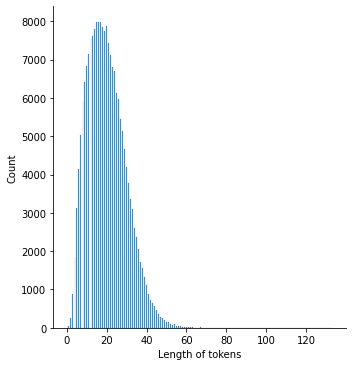

In [ ]:
all_tokens = [word for tokens in data['tokens'] for word in tokens]
print('전체 토큰 수:', len(all_tokens))
vocab = sorted(list(set(all_tokens)))
print('중복 제외 전체 토큰 수:', len(vocab))
print('토큰 최대 길이:', max(data['tokens'].str.len()))
print('토큰 평균 길이:', np.mean(data['tokens'].str.len()))
sns.displot([len(s) for s in data['tokens']])
plt.xlabel('Length of tokens')
plt.ylabel('Count')
plt.show();

In [ ]:
%%time

w2v_model = Word2Vec(sentences=data['tokens'], 
                     size=300, # 벡터 차원
                     window=5, 
                     min_count=5, # 최소 단어
                     workers=4, 
                     sg=0, # CBOW, 왜 CBOW가 skipgram보다 잘 나오는걸까?
                     seed = 34
                     )

CPU times: user 1min 26s, sys: 200 ms, total: 1min 26s
Wall time: 30.1 s


In [ ]:
w2v_model.wv.vectors.shape

(28834, 300)

In [ ]:
print('말뭉치 내 토큰들의 유사도')
print(w2v_model.wv.similarity('삼성', '전자'))
print(w2v_model.wv.similarity('대통령', '청와대'))
print(w2v_model.wv.similarity('경제', '위기'))
print(w2v_model.wv.similarity('경제', '사랑'))
print(w2v_model.wv.similarity('야구', '범죄'))
print(w2v_model.wv.similarity('야구', '선수'))

말뭉치 내 토큰들의 유사도
0.5269951
0.5485726
0.38728228
-0.050720997
-0.15481834
0.71805745


In [ ]:
print(len(w2v_model.wv.vocab))
vects = w2v_model.wv.vectors
vects.shape
num_clusters = 3

28834


In [ ]:
km = KMeans(n_clusters=num_clusters)
idx = km.fit_predict(vects).tolist()

In [ ]:
names = w2v_model.wv.index2word
word_centroid_map = {names[i]: idx[i] for i in range(len(names))}

for cluster in range(3):
    print(f'Cluster {cluster}')

    words = []
    for i in range(0, len(list(word_centroid_map.values()))):
        if (list(word_centroid_map.values())[i]) == cluster:
            words.append(list(word_centroid_map.keys())[i])
    
    print(words)

Cluster 0
['에서', '다며', '에게', '면서', '대표', '까지', '이날', '전했', '감독', '다면서', '함께', '지난', '부터', '회장', '서울', '모두', '교수', '선수', '당시', '이후', '최고', '일본', '자리', '시작', '학생', '열린', '역할', '처럼', '이어', '지난해', '직접', '바란다고', '사고', '오후', '상태', '행사', '오전', '모습', '사장', '동안', '된다며', '본부', '직원', '이미', '로서', '중앙', '인데', '보여', '가족', '아이', '실장', '으며', '상대', '너무', '앞서', '여성', '역시', '원장', '다음', '처음', '방문', '라면서', '인터뷰', '해도', '참석', '아울러', '방송', '시즌', '스럽', '한편', '특별', '그동안', '훈련', '하지만', '희망', '고자', '회견', '전화', '대회', '다가', '삼성', '간담회', '조금', '기록', '공식', '보였', '시기', '이사', '여러분', '정말', '반응', '사랑', '병원', '힘들', '분위기', '로부터', '구단', '지사', '사이', '더불', '보내', '부장', '라면', '또한', '소속', '에선', '롯데', '조선', '마지막', '소개', '운동', '가진', '시켜', '승리', '축구', '공격', '리그', '가운데', '개월', '협회', '트럼프', '교사', '스포츠', '생명', '마다', '광주', '이끌', '마무리', '차례', '여기', '조언', '나왔', '부총리', '야구', '려면', '개최', '소장', '으로부터', '홍보', '과학', '앞두', '출신', '지난달', '는다며', '월일', '친구', '으니', '시험', '주변', '부산', '반면', '재단', '열심히', '국장', '도전', '하루', '대신', '아서', '청장', '얼마나', '부회

#### bokeh plot

In [ ]:
import bokeh.io
from bokeh.io import push_notebook, show, output_notebook, save, output_file
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet

source = ColumnDataSource.from_df(cluster_df[['x', 'y', 'color', 'tokens']])
tooltips = [('tokens', '@tokens')]
tools = "pan, wheel_zoom, box_zoom, reset, hover"

plot = figure(plot_width=800, plot_height=450, tooltips=tooltips, tools=tools, title='200,000 news clustering')

plot.circle(y='y', x='x', source=source, size=15, fill_color='color')
show(plot)

# output_file("clustering.html")
# save(plot)
# 2021년 4월 28일 오후 8:16의 실행 결과
# 	text/plain
# 		'/content/clustering.html'

In [ ]:
!pip freeze > requirements.txt